# Solution

In [1]:
# put all python import statements here

from solvers import solver
from typing import Callable, List, Tuple, TypeVar
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import timeit
import psutil
from scipy.signal import find_peaks

## Implementation


### Briefing of Implementation

The objective of this notebook is to assess 3 numerical methods and compare their computational efficiency and accuracy against each other. Upon preliminatry research, methods began to stand out due to the concept of the "Order" of each method. The 2 selected methods are the Runge-Kutta method, and the SSPRK3 method. Each method will be compared against a baseline method (in the reports case, the Euler method (a 1st order method) was chosen), to prove the effectiveness and accuacy of a 4th and 3rd order method over a 1st. The necessary functions have been constructed below.

As a word of warning, the computational time taken to run the simulation is long (over 5 minutes on an intel core I7 11th gen cpu)

In [2]:
# A static variable pre-defiend for looping how many times 1 numerical method of 1 specific dt value is repeated
# Done to calculate average time taken for each numerical method
# THE USER CAN CHANGE THIS, ideally to something >= 3
TIMES_TO_REPEAT_NUMERICAL_METHOD = 5

# Static variable to indicate how many dt's one would like to calculate (dt)
NUMBER_OF_DTS_TO_CALCULATE = 8

# Class for storing data 
class Method_Data:

    def __init__(self, part_flag: str) -> None:
        self.part_flag = part_flag
        self.data_list_Prey = []
        self.data_list_Predator = []
        self.time_list = []
        self.time_taken = []

    # Setter methods
    def add_to_Prey_list(self, prey_list):
        self.data_list_Prey.append(prey_list)
    
    def add_to_Predator_list(self, predator_list):
        self.data_list_Predator.append(predator_list)

    def add_to_time_list(self, time_list):
        self.time_list.append(time_list)

    def add_to_time_taken_list(self, time_taken_list):
        self.time_taken.append(time_taken_list)

    # Getter methods
    def get_part(self):
        return self.part_flag

    def get_Prey_list(self):
        return self.data_list_Prey
    
    def get_Predator_list(self):
        return self.data_list_Predator
    
    def get_time_list(self):
        return self.time_list
    
    def get_time_taken_list(self):
        return self.time_taken

# Set up 2 global dictionaries to store 3 Method_Data classes
Data_To_Store_For_A = {}
Data_To_Store_For_B = {}

# Set up names for methods to be used for the report
Names_Of_Methods = ["Euler", "SSPRK3", "Runge-Kutta"]

# Statically define T values for parts A and B
T_VALUE_FOR_PART_A = 2.5 * np.pi
T_VALUE_FOR_PART_B = 30

# Statically define all known methods into their respective order tables
FIRST_ORDER_METHODS = ["Euler"]
SECOND_ORDER_METHODS = ["Heun", "Ralston"]
THIRD_ORDER_METHODS = ["SSPRK3", "Van De Houwen"]
FOURTH_ORDER_METHODS = ["Runge-Kutta", "Ralston-4", "3/8-rule"]

In [3]:
# Implementing Eulers method as a standalone function
# Major elements of this function has been derived from the solver function, but has been adapted to work for the Euler method only
# Sequencing needs to be the same or very similar to the original solver function for accurate time measurement and comparison (occurs later on)

# types for y variable in solver
y_type = TypeVar("y_type", np.ndarray, np.double)

def Eulers_Method(
    rhs: Callable[[np.double, y_type], y_type],
    y0: y_type,
    t0: np.double,
    dt: np.double,
    T: np.double,
) -> Tuple[List[np.double], List[y_type]]:

    # set initial data into solution arrays
    t_out = [t0]
    y_out = [y0]

    # extract method helpers
    matrix = np.array([[0.0]])
    weights = np.array([1])
    nodes = np.array([0.0])
    
    s = len(weights)
    k: List[y_type | None] = [None for _ in range(s)]

    # count steps
    timesteps = int(T / dt)

    # time loop
    for step in range(timesteps):
        # build k's
        for i in range(s):
            temp = sum(matrix[i, j] * k[j] for j in range(i))
            k[i] = rhs(t_out[-1] + dt * nodes[i], y_out[-1] + dt * temp)

        y_update = sum([k[i] * weights[i] for i in range(s)])

        y_new = y_out[-1] + dt * y_update
        t_new = t_out[-1] + dt

        t_out.append(t_new)
        y_out.append(y_new)

    return t_out, y_out

In [4]:
### FOR PART A ###

# Implementing function f for Prey models
def Function_F_For_A(t: np.double) -> np.double:
    return -np.sin(t) - (np.cos(t)**2) - np.cos(t)

# Implementing function g for Predator models
def Function_G_For_A(t: np.double) -> np.double:
    return np.sin(t) + (np.cos(t)**2) - np.cos(t)

# Set equations for true value predator and prey
def True_Value_Prey_Eqn(t) -> np.double:
    return 1 + np.cos(t)

def True_Value_Predator_Eqn(t) -> np.double:
    return 1 - np.cos(t)

In [5]:
### FOR PART B ###

# The report recognises these functions are a bit useless, but again they are here for consistency against the functions for A

# Implementing function f for Prey models
def Function_F_For_B(t: np.double) -> np.double:
    return 0.0

# Implementing function g for Predator models
def Function_G_For_B(t: np.double) -> np.double:
    return 0.0

In [6]:
# Implementing function derivative for RHS of prey and predator models, for both part A and B

def RHS_Prey_Predator_System_For_A(t: np.double, y: np.ndarray):
    Prey_Derivative_dxdt = alpha * y[0] - beta * y[0] * y[1] + Function_F_For_A(t)
    Predator_Derivative_dydt = delta * y[0] * y[1] - gamma * y[1] + Function_G_For_A(t)
    
    return np.array([Prey_Derivative_dxdt, Predator_Derivative_dydt])

def RHS_Prey_Predator_System_For_B(t: np.double, y: np.ndarray):
    Prey_Derivative_dxdt = alpha * y[0] - beta * y[0] * y[1] + Function_F_For_B(t)
    Predator_Derivative_dydt = delta * y[0] * y[1] - gamma * y[1] + Function_G_For_B(t)
    
    return np.array([Prey_Derivative_dxdt, Predator_Derivative_dydt])


#### Calculating the Methods
Because of the size and repetition variables being tested for each method, the below code snippet will take some time to calculate (approx 5 or more minutes). You can change this by editing the TIMES_TO_REPEAT_NUMERICAL_METHOD constant variable to a number greater than or equal to 3, as this variable relates to the average time taken to compute each method. This should still provide an excellent average for the time taken to compute values

In [7]:
# Calculating and storing tables for each method used

# Initialise data storage classes in a dictionary to store Euler, Runge-Kutta and Ralston-4 methods
def Set_Up_Dict(Dict: dict, part: str):

    # Each list will contain a list inside, corresponding to its related dt value (dt of 1/100 is index 0, dt of 1/200 is index 1, etc) 
    for method_type_count in range(len(Names_Of_Methods)):

        # Store name of method as key, and data storage class to dict for easy lookup
        key = Names_Of_Methods[method_type_count]
        value = Method_Data(part)
        Dict[key] = value


# Run through each data point inside the dict, and calculate all data values for each one base on which part to run for
def Get_Data(Dict: dict):

    # Loop through each item in the dict
    for key, value in Dict.items():
        Run_Numerical_Method(key, value, value.get_part())
        

# For all methods, run the function x times, increasing the number of timesteps taken by (100 * 2^x)  NUMBER_OF_DTS_TO_CALCULATE
def Run_Numerical_Method(Name_of_Method: str, Data_To_Store_To_Method: Method_Data, part: str):

    # Initialise global variables for the RHS algorithms
    global alpha, beta, gamma, delta
    
    # Set values according to part to run
    if part == "A":
        T_Value = T_VALUE_FOR_PART_A
        RHS_Prey_Predator_System = RHS_Prey_Predator_System_For_A
        alpha = beta = gamma = delta = np.double(1.0)
        variables_x_and_y = np.array([2.0, 0.0])
    elif part == "B":
        T_Value = T_VALUE_FOR_PART_B
        alpha = np.double(2.0/3.0)
        beta = np.double(4.0/3.0)
        gamma = delta = np.double(1.0)
        variables_x_and_y = np.array([0.9, 0.9])
        RHS_Prey_Predator_System = RHS_Prey_Predator_System_For_B

    # Run through each dt
    for method_Count in range(NUMBER_OF_DTS_TO_CALCULATE):

        # Set up list to store time values to
        time_Values = []

        # Repeat to get time taken for every numberical method, for 1 specific dt
        for process_Number in range(TIMES_TO_REPEAT_NUMERICAL_METHOD):
            
            # Lock 1 core for use in calculating time spent
            target_core = 0

            # Get current process ID
            process_id = psutil.Process()

            # Set CPU affinity to the specified core
            process_id.cpu_affinity([target_core])

            # Find out which method to run, based on the key provided
            if Name_of_Method == "Euler":

                # Record the start time
                start_time = timeit.default_timer()

                # Run selected method
                t, y = Eulers_Method(RHS_Prey_Predator_System, variables_x_and_y, 0.0, 1/(100 * (2**method_Count)), T_Value)
                
                # Record the end time
                end_time = timeit.default_timer()
            
            else:
                # Record the start time
                start_time = timeit.default_timer()

                # Run selected method
                t, y = solver(RHS_Prey_Predator_System, variables_x_and_y, 0.0, 1/(100 * (2**method_Count)), T_Value, Name_of_Method)
                
                # Record the end time
                end_time = timeit.default_timer()            

            # Free core at the end of timer
            process_id.cpu_affinity(None)

            # get and store elapsed time
            elapsed_time = end_time - start_time

            time_Values.append(elapsed_time)       

        # Stack and transpose for list of x, y, values
        stacked_Y_values = np.vstack(y)
        transposed_Y_values = stacked_Y_values.T
        y_list = transposed_Y_values.tolist()

        # Store results inside respective arrays
        Data_To_Store_To_Method.add_to_Prey_list(y_list[0])
        Data_To_Store_To_Method.add_to_Predator_list(y_list[1])
        Data_To_Store_To_Method.add_to_time_list(t)
        Data_To_Store_To_Method.add_to_time_taken_list(time_Values)


# Run setup of both data dicts
Set_Up_Dict(Data_To_Store_For_A, "A")
Get_Data(Data_To_Store_For_A)

Set_Up_Dict(Data_To_Store_For_B, "B")
Get_Data(Data_To_Store_For_B)


In [8]:
# Output resulting graphs, and true value comparisons if part A is indicated
def Output_Main_Graphs(data_dict: dict, data_to_plot: str):

    # Create a bool flag if part A is being calculated
    if data_dict["Euler"].get_part() == "A":
        flag_for_part_a = True
    else:
        flag_for_part_a = False
    
    # Get true value graphs for A according to the data_to_plot parameter, if the flag is set to true
    if flag_for_part_a and data_to_plot == "Predator":

        # Generate t values
        t_values = np.linspace(0, T_VALUE_FOR_PART_A, int((T_VALUE_FOR_PART_A) * (100 * (2 ** NUMBER_OF_DTS_TO_CALCULATE))) + 1, dtype = np.float64)

        # Calculate x values
        y_values = True_Value_Predator_Eqn(t_values)

    elif flag_for_part_a and data_to_plot == "Prey":

        # Generate t values
        t_values = np.linspace(0, T_VALUE_FOR_PART_A, int((T_VALUE_FOR_PART_A) * (100 * (2 ** NUMBER_OF_DTS_TO_CALCULATE))) + 1, dtype = np.float64)

        # Calculate x values
        x_values = True_Value_Prey_Eqn(t_values)


    # Set up plots for graph (3 methods, 3 graphs)
    plt.figure(figsize=(25, 5))
    fig, ax = plt.subplots(1, len(data_dict), figsize = (25, 5))

    # Loop through each method
    for count, (key, data) in enumerate(data_dict.items(), start = 0):

        # Retrieve necessary data to plot
        time_data = data.get_time_list()
        
        # Gather and plot necessary data
        if data_to_plot == "Predator":
            
            # Set y axis label to predator related calculations
            ax[count].set_ylabel("Rate of Change for Predator, dy/dt")
            
            # Retrieve necessary data to plot
            data = data.get_Predator_list()

            # Output true value line if flag was set
            if flag_for_part_a:
                ax[count].plot(t_values, y_values, label = "True Values (1-cos(t))", linewidth = 1)

        elif data_to_plot == "Prey":

            # Set y axis label to predator related calculations
            ax[count].set_ylabel("Rate of Change for Prey, dx/dt")

            # Retrieve necessary data to plot
            data = data.get_Prey_list()

            # Output true value line if flag was set
            if flag_for_part_a:
                ax[count].plot(t_values, x_values, label = "True Values (1+cos(t))", linewidth = 1)

        # Set x axis label to time (t)
        ax[count].set_xlabel("Time, t")

        # Plot all data inside subgraphs
        for dataset_no, (data, time) in enumerate(zip(data, time_data)):

            # Plot d/dt lines
            label = int((100 * (2 ** dataset_no)))
            ax[count].plot(time, data, label = f"1/dt = {label}", linewidth = 1)
            ax[count].set_title(key)
            ax[count].legend()
        
    # Set main title of graphs
    if flag_for_part_a:
        plt.suptitle(f"{data_to_plot} Graphs, Part A") 
    else:
        plt.suptitle(f"{data_to_plot} Graphs, Part B")
            
    plt.tight_layout()
    plt.show()


In [9]:
# Outputs a table to show the tendancy for the maxima over lower dt values
# Will only work for Part B, since Part A has only 1 peak
def Output_Maxima_Graph_For_Part_B(data_dict: dict, data_to_plot: str):

    # Set up graph (1 figure containing 3 graphs, 5 legends for each dt value)
    plt.figure(figsize=(25, 5))
    fig, ax = plt.subplots(1, len(data_dict), figsize = (25, 5))

    # Loop through each method
    for count, (key, data) in enumerate(data_dict.items(), start = 0):

        # Gather and plot necessary data
        if data_to_plot == "Predator":
            # Retrieve necessary data to plot
            data = data.get_Predator_list()
        elif data_to_plot == "Prey":
            # Retrieve necessary data to plot
            data = data.get_Prey_list()

        # Looping through each list inside the predator and prey data
        for dataset_no, data_list in enumerate(data):

            # Set up list to store values of index to
            data_peak_list = []

            # Obtain index for peaks for each set of values
            data_peaks_index_list, _ = find_peaks(data_list)

            # Get values using the index as look up reference
            for dt_no, data_index in enumerate(data_peaks_index_list):
                
                # Save the value of the peak to the data peak list
                data_peak_list.append(data_list[data_index])

            # Find number of peaks found
            number_of_data_peaks = len(data_peak_list)
        
            peaks_list = range(1, number_of_data_peaks + 1)

            # Plot peaks according to the order they were found
            ax[count].plot(peaks_list, data_peak_list, label = f"1/dt = {100 * (2 ** dataset_no)}", marker = "o")
            
            ax[count].legend()
        
        # Set titles of axis and subgraph
        ax[count].set_title(key)
        ax[count].set_xlabel("Peak Number")
        ax[count].set_ylabel("Peak Value")
        # Set x-axis ticks to integers with an interval of 1
        ax[count].set_xticks(range(int(min(peaks_list)), int(max(peaks_list)), 1))
            

    # Set main title of graphs and show
    plt.suptitle(f"{data_to_plot} Graphs, Part B")
    plt.tight_layout()
    plt.show()

In [10]:
# Output "time taken to compute" graphs
def Output_Time_Graph(data_dict: dict, flag_for_part_a: bool):

    # Set up table values
    table_Values = []

    # Set up 1/dt values to plot for graph
    dt_Values = []
    for dt_no in range(NUMBER_OF_DTS_TO_CALCULATE):
        dt_Values.append((100 * (2**dt_no)))

    # Set up plots for graph (1 graph per part)
    plt.figure(figsize=(15, 10))
    plt.xlabel("1/dt Value")
    plt.ylabel(f"Average time taken, {TIMES_TO_REPEAT_NUMERICAL_METHOD} repeats")

    # Loop through each method
    for (key, data) in data_dict.items():

        # Set up average time taken list
        average_time_taken_list = []

        # Retrieve necessary data to plot
        time_taken_data = data.get_time_taken_list()

        # Fins and store the average time taken for each method
        for time_taken_list in time_taken_data:
            
            # Calculate average time taken in list
            average_time_taken = np.sum(time_taken_list)/len(time_taken_list)

            # Save the average time into an array
            average_time_taken_list.append(average_time_taken)

        # Plot 1/dt against time taken lines
        plt.plot(dt_Values, average_time_taken_list, label = f"{key} method", linewidth = 1, marker = "o")
        plt.legend()

        # Calculate gradient and average gradient
        gradient = np.gradient(average_time_taken_list, dt_Values)
        average_gradient = np.sum(gradient)/len(gradient)

        # Store a baseline value (should be Euler's method, or any 1st order method) to compare other methods to
        if len(table_Values) == 0:
            baseline_method_average_result = average_gradient

        # Calculate the factor of the currently run method to the baseline method
        relative_factor_against_baseline_method = average_gradient / baseline_method_average_result

        # Derive order of method from the factor calculated
        calculated_order = int(round(relative_factor_against_baseline_method))

        # Eliminate the 1 if it was calculated as the order (for presentation purposes)
        if calculated_order == 1:
            calculated_order = ""

        # Add relative data to table values
        if key in FIRST_ORDER_METHODS:
            table_Values.append((key, average_gradient, relative_factor_against_baseline_method, "O(n)", f"O({calculated_order}n)"))
        elif key in SECOND_ORDER_METHODS:
            table_Values.append((key, average_gradient, relative_factor_against_baseline_method, f"O(2n)", f"O({calculated_order}n)"))
        elif key in THIRD_ORDER_METHODS:
            table_Values.append((key, average_gradient, relative_factor_against_baseline_method, f"O(3n)", f"O({calculated_order}n)"))
        elif key in FOURTH_ORDER_METHODS:
            table_Values.append((key, average_gradient, relative_factor_against_baseline_method, f"O(4n)", f"O({calculated_order}n)"))
        
    # Set main title of graphs and show
    if flag_for_part_a:
        plt.suptitle("Average time taken to compute each process, Part A") 
    else:
        plt.suptitle("Average time taken to compute each process, Part B")
            
    plt.tight_layout()
    plt.show()

    # Set titles for gradient table and output
    headers = ["Method", "Gradient", "Multiplicative Factor against Euler's Method", "Intended O(n) for Method", "Calculated O(n) for Method"]
    table = tabulate(table_Values, headers = headers, tablefmt = "fancy_grid")
    
    # Output title for table according to what part is being computed
    if flag_for_part_a:
        print(f"Part A, Calculating Big-O for each Process")
    else:
        print(f"Part B, Calculating Big-O for each Process")
    
    # Output table
    print(table)

In [11]:
# Outputs a table representing the predator and prey absolute error and euclidean norm, for each method and 1/dt value.
# Outputs for Part A only, since there is no true value to compare part B to
def Output_Error_Tables_And_Graphs_For_Part_A():

    # Set up 1/dt values to plot for graph
    dt_Values = []
    for dt_no in range(NUMBER_OF_DTS_TO_CALCULATE):
        dt_Values.append((100 * (2**dt_no)))

    # Set up 1st set of graphs to plot Eulcidean norm against 1/dt values
    plt.figure(figsize = (25,10))
    fig, ax = plt.subplots(1, 2, figsize = (25, 10))

    ax[0].set_yscale("log")
    ax[0].set_xscale("log", base=2)
    ax[0].set_xticks(dt_Values, [str(int(val)) for val in dt_Values])
    ax[0].set_ylim(1e-11, 1e1)
    ax[0].set_xlabel("1/dt, log scale")
    ax[0].set_ylabel("Euclidean Norm, log scale")
    ax[0].set_title("Predator Error Values")

    ax[1].set_yscale("log")
    ax[1].set_xscale("log", base=2)
    ax[1].set_xticks(dt_Values, [str(int(val)) for val in dt_Values])
    ax[1].set_ylim(1e-11, 1e1)
    ax[1].set_xlabel("1/dt, log scale")
    ax[1].set_ylabel("Euclidean Norm, log scale")
    ax[1].set_title("Prey Error Values")

    plt.suptitle("Euclidean Norm against 1/dt Values, Part A")

    # Set up graphs to plot Prey error values against time, 1 subgraph for each method
    fig2, ax2 = plt.subplots(1, len(Data_To_Store_For_A), figsize = (25, 10))
    plt.suptitle("Prey Absolute Error Values against Time, Part A")

    # Set up graphs to plot Predator error values against time, 1 subgraph for each method
    fig3, ax3 = plt.subplots(1, len(Data_To_Store_For_A), figsize = (25, 10))
    plt.suptitle("Predator Absolute Error Values against Time, Part A")

    # Set up list to store error gradient tables, for predator and prey
    data_for_average_error_gradient_predator = []
    data_for_average_error_gradient_prey = []

    # Looping through each key-value pair
    for count, (key, value) in enumerate(Data_To_Store_For_A.items()):
        
        # Initialise lists to store max, average error and euclidean norm
        predator_max_error_list = []
        prey_max_error_list = []

        predator_average_error_list = []
        prey_average_error_list = []

        predator_euclidean_norm_list = []
        prey_euclidean_norm_list = []

        # Get predator, prey, time data
        predator_data = value.get_Predator_list()
        prey_data = value.get_Prey_list()
        time_data = value.get_time_list()

        # Extract lists from data
        for list_count, (predator_list, prey_list, time_list) in enumerate(zip(predator_data, prey_data, time_data)):

            # Initialise list to store predator and prey absolute error data values, max and average
            predator_error_list = []
            prey_error_list = []

            # Get true value graphs for A according to the time_data list
            # Calculate y values
            y_true_values = True_Value_Predator_Eqn(time_list)
            # Calculate x values
            x_true_values = True_Value_Prey_Eqn(time_list)

            # Extract and save values from list as absolute error values
            predator_error_list = np.abs(predator_list - y_true_values)
            prey_error_list = np.abs(prey_list - x_true_values)

            # Calculate average and max values and euclidean norm
            max_predator_error_value = max(predator_error_list)
            max_prey_error_value = max(prey_error_list)

            average_predator_error_value = np.sum(predator_error_list) / len(predator_error_list)
            average_prey_error_value = np.sum(prey_error_list) / len(prey_error_list)

            euclidean_norm_predator = np.linalg.norm(predator_error_list)
            euclidean_norm_prey = np.linalg.norm(prey_error_list)

            # Store all values to list
            predator_max_error_list.append(max_predator_error_value)
            prey_max_error_list.append(max_prey_error_value)

            predator_average_error_list.append(average_predator_error_value)
            prey_average_error_list.append(average_prey_error_value) 

            predator_euclidean_norm_list.append(euclidean_norm_predator)
            prey_euclidean_norm_list.append(euclidean_norm_prey)

            # Plot predator and prey graphs to show aboslute error against time (t)
            ax2[count].plot(time_list, predator_error_list, label = f"{100 * (2**list_count)}, Predator")
            ax3[count].plot(time_list, prey_error_list, label = f"{100 * (2**list_count)}, Prey")
            ax2[count].set_yscale("log")
            ax3[count].set_yscale("log")
            ax2[count].legend()
            ax3[count].legend()
        
        # Set up table data
        headers = ["1/dt", "Maximum absolute error", "Average absolute error", "Euclidean norm"]
        data_for_predator_table = []
        data_for_prey_table = []

        # Set predator error data for table 
        for (dt_Value, predator_max_error, predator_average_error, predator_euclidean_norm) in zip(dt_Values, predator_max_error_list, predator_average_error_list, predator_euclidean_norm_list):
            data_for_predator_table.append((dt_Value, predator_max_error, predator_average_error, predator_euclidean_norm))
            
        # Set prey error data for table 
        for (dt_Value, prey_max_error, prey_average_error, prey_euclidean_norm) in zip(dt_Values, prey_max_error_list, prey_average_error_list, prey_euclidean_norm_list):
            data_for_prey_table.append((dt_Value, prey_max_error, prey_average_error, prey_euclidean_norm))
        
        # Create tables
        predator_table = tabulate(data_for_predator_table, headers = headers, tablefmt = "fancy_grid")
        prey_table = tabulate(data_for_prey_table, headers = headers, tablefmt = "fancy_grid")
        
        # Output tables
        print(f"Error values for {key} method, Predator, part A")
        print(predator_table, "\n")

        print(f"Error values for {key} method, Prey, part A")
        print(prey_table, "\n\n")

        # Get the 1st values of the average error list
        predator_average_error_lowest_value = predator_average_error_list[0]
        prey_average_error_lowest_value = prey_average_error_list[0]

        # Logically, we want to create a loop to find the lowest element to calculate the respective gradient between the 1st and smallest euclidean norm number, and the respective dt values,
        # so we can calculate gradients of all straight line elements only
        for element_count in range(len(predator_average_error_list) - 1):
        
            # Check for lowest element in list
            if prey_average_error_list[element_count + 1] < prey_average_error_lowest_value and predator_average_error_list[element_count + 1] < predator_average_error_lowest_value:
                
                # Set new lowest values
                prey_average_error_lowest_value = prey_average_error_list[element_count + 1]
                predator_average_error_lowest_value = predator_average_error_list[element_count + 1]
                dt_index = element_count + 1
            
            # Terminate loop if lowest is found
            else:
                break

        # General formula for expected error = coefficient * (step_size ^ order)
        # can be translated to log(error) = log(coefficient) + order * log(step_size)
        # Want to find gradient to prove order indeed follows this trend
        # Set necessary difference values
        predator_difference_in_A_E = np.log(predator_average_error_list[0]) - np.log(predator_average_error_lowest_value)
        prey_difference_in_A_E = np.log(prey_average_error_list[0]) - np.log(prey_average_error_lowest_value)
        difference_in_step_size = np.log2(dt_Values[0]) - np.log2(dt_Values[dt_index])

        # Calculate gradients
        predator_average_error_gradient = predator_difference_in_A_E / difference_in_step_size
        prey_average_error_gradient = prey_difference_in_A_E / difference_in_step_size

        # Set baseline gradient
        if count == 0:
            baseline_predator_average_error = predator_average_error_gradient
            baseline_prey_average_error = prey_average_error_gradient

        # Calculate multiplicative factor
        multiplicative_factor_predator = predator_average_error_gradient / baseline_predator_average_error
        multiplicative_factor_prey = prey_average_error_gradient / baseline_prey_average_error

        # Calculate order of each method
        calculated_order_predator = np.round(multiplicative_factor_predator)
        calculated_order_prey = np.round(multiplicative_factor_prey)        

        # Store gradients directly to table according to Method order
        if key in FIRST_ORDER_METHODS:
            data_for_average_error_gradient_predator.append((key, "1", predator_average_error_gradient, multiplicative_factor_predator, calculated_order_predator))
            data_for_average_error_gradient_prey.append((key, "1", prey_average_error_gradient, multiplicative_factor_prey, calculated_order_prey))
        elif key in SECOND_ORDER_METHODS:
            data_for_average_error_gradient_predator.append((key, "2", predator_average_error_gradient, multiplicative_factor_predator, calculated_order_predator))
            data_for_average_error_gradient_prey.append((key, "2", prey_average_error_gradient, multiplicative_factor_prey, calculated_order_prey))
        elif key in THIRD_ORDER_METHODS:
            data_for_average_error_gradient_predator.append((key, "3", predator_average_error_gradient, multiplicative_factor_predator, calculated_order_predator))
            data_for_average_error_gradient_prey.append((key, "3", prey_average_error_gradient, multiplicative_factor_prey, calculated_order_prey))
        elif key in FOURTH_ORDER_METHODS:
            data_for_average_error_gradient_predator.append((key, "4", predator_average_error_gradient, multiplicative_factor_predator, calculated_order_predator))
            data_for_average_error_gradient_prey.append((key, "4", prey_average_error_gradient, multiplicative_factor_prey, calculated_order_prey))


        # Plot graphs of predator and prey max error against 1/dt values
        ax[0].plot(dt_Values, predator_euclidean_norm_list, label = f"{key} method", marker = "o")
        ax[1].plot(dt_Values, prey_euclidean_norm_list, label = f"{key} method", marker = "o")
        ax[0].legend()
        ax[1].legend()
        
        # Set titles for graphs for absolute error against time
        ax2[count].set_title(key)
        ax2[count].set_ylabel("Absolute Error")
        ax2[count].set_xlabel("Time")

        ax3[count].set_title(key)
        ax3[count].set_ylabel("Absolute Error")
        ax3[count].set_xlabel("Time")

    # Show graph
    plt.tight_layout()
    plt.show()

    # Set up and show predator and prey tables showing gradient of the average error
    table_Values_Predator = ["Method", "Order of Method", "Predator Average Error Gradient", "Multiplicative Factor against Euler's Method", "Order Calculated for Predator Error Values"]
    table_Values_Prey = ["Method", "Order of Method", "Prey Average Error Gradient", "Multiplicative Factor against Euler's Method", "Order Calculated for Prey Error Values"]
    
    gradient_table_predator = tabulate(data_for_average_error_gradient_predator, headers = table_Values_Predator, tablefmt = "fancy_grid")
    gradient_table_prey = tabulate(data_for_average_error_gradient_prey, headers = table_Values_Prey, tablefmt = "fancy_grid")
    
    print(gradient_table_predator)
    print(gradient_table_prey)

## Results

We begin by demonstrating the simulated results for parts A and B, calculated via the equations provided in solver to apply the SSPRK3 and Runge-Kutta methods, and an equation created by the author to apply the euler method.



<Figure size 2500x500 with 0 Axes>

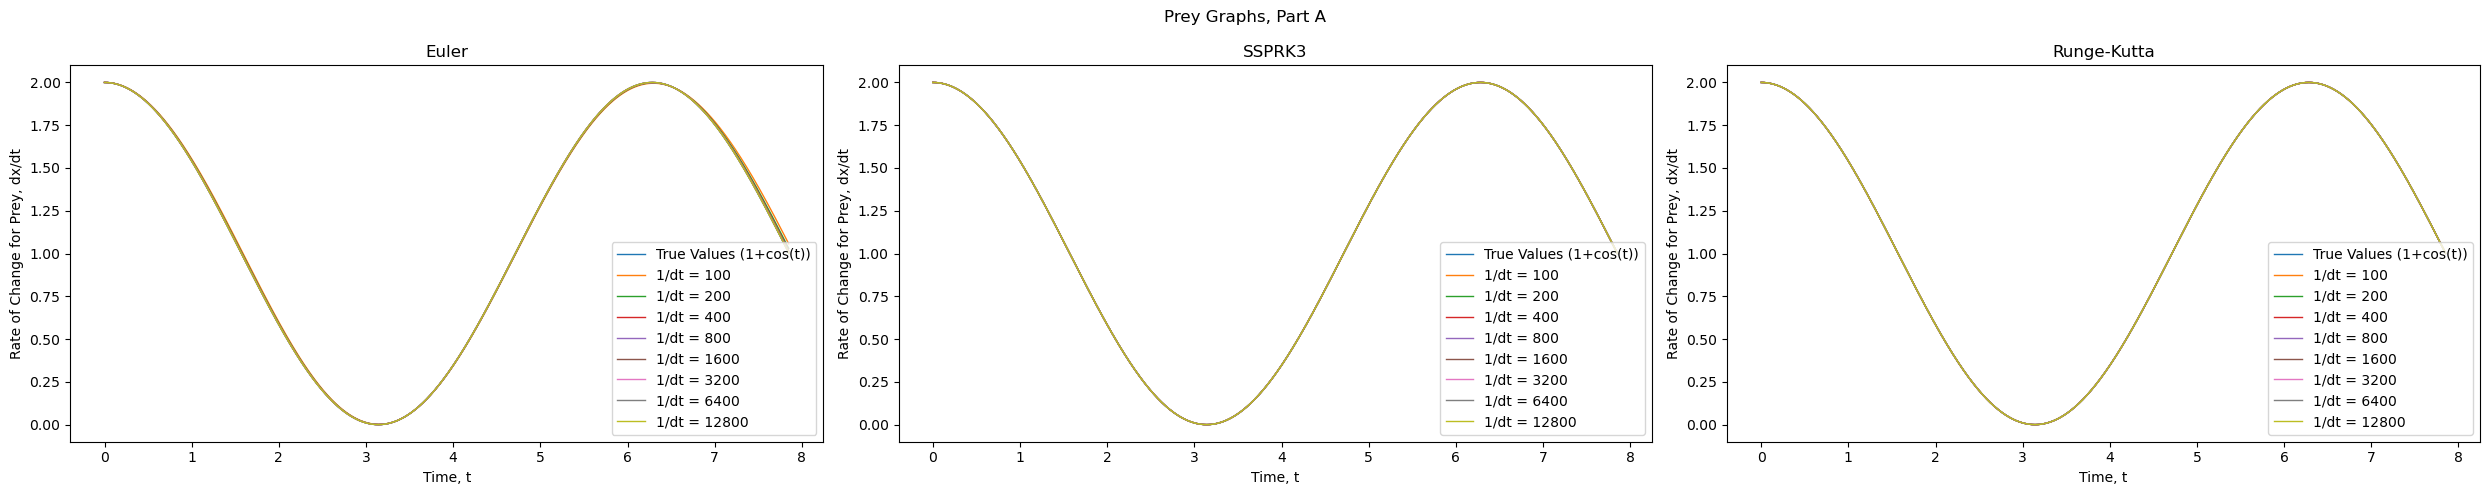

<Figure size 2500x500 with 0 Axes>

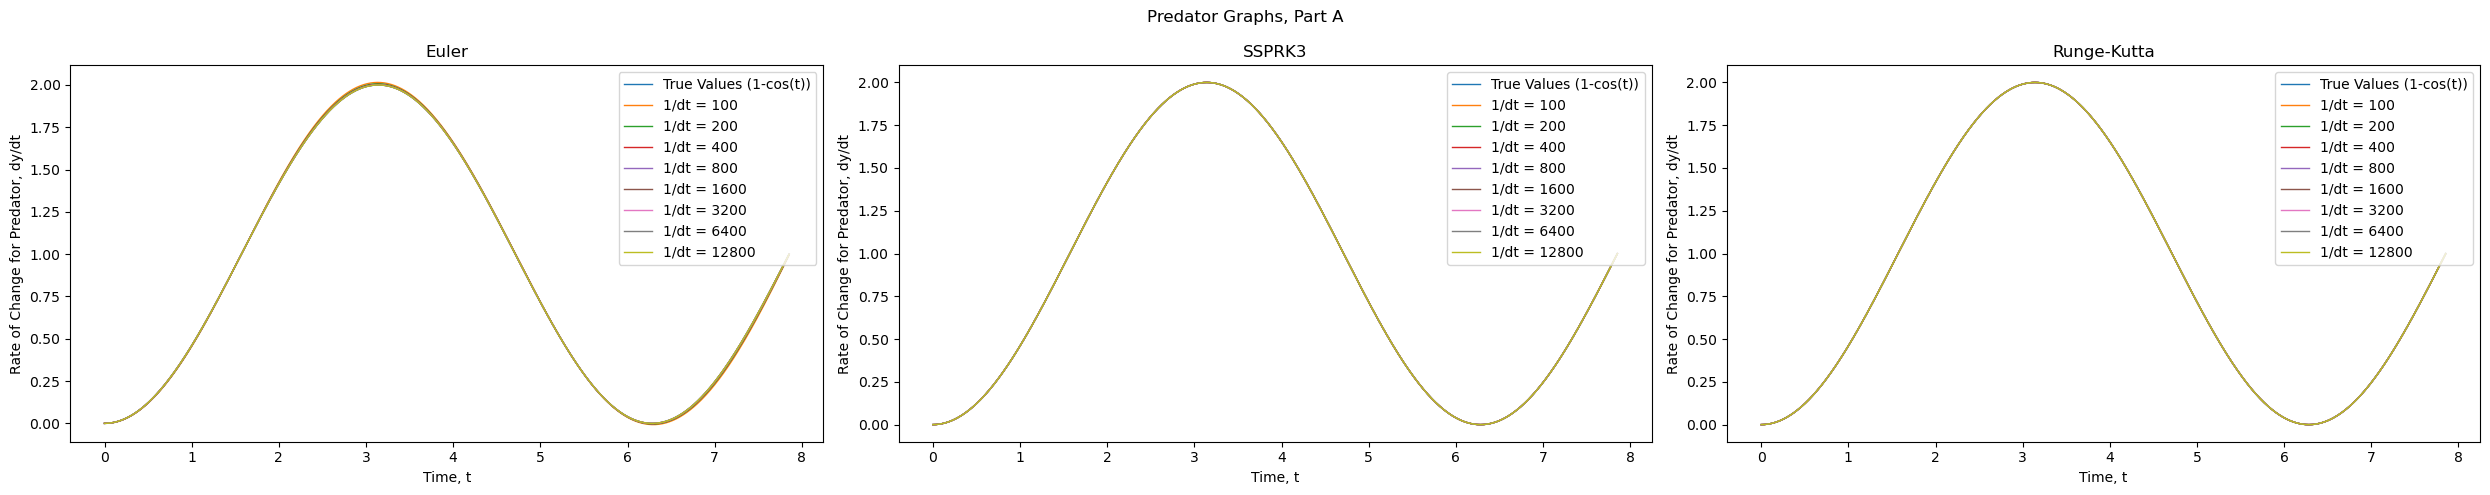

<Figure size 2500x500 with 0 Axes>

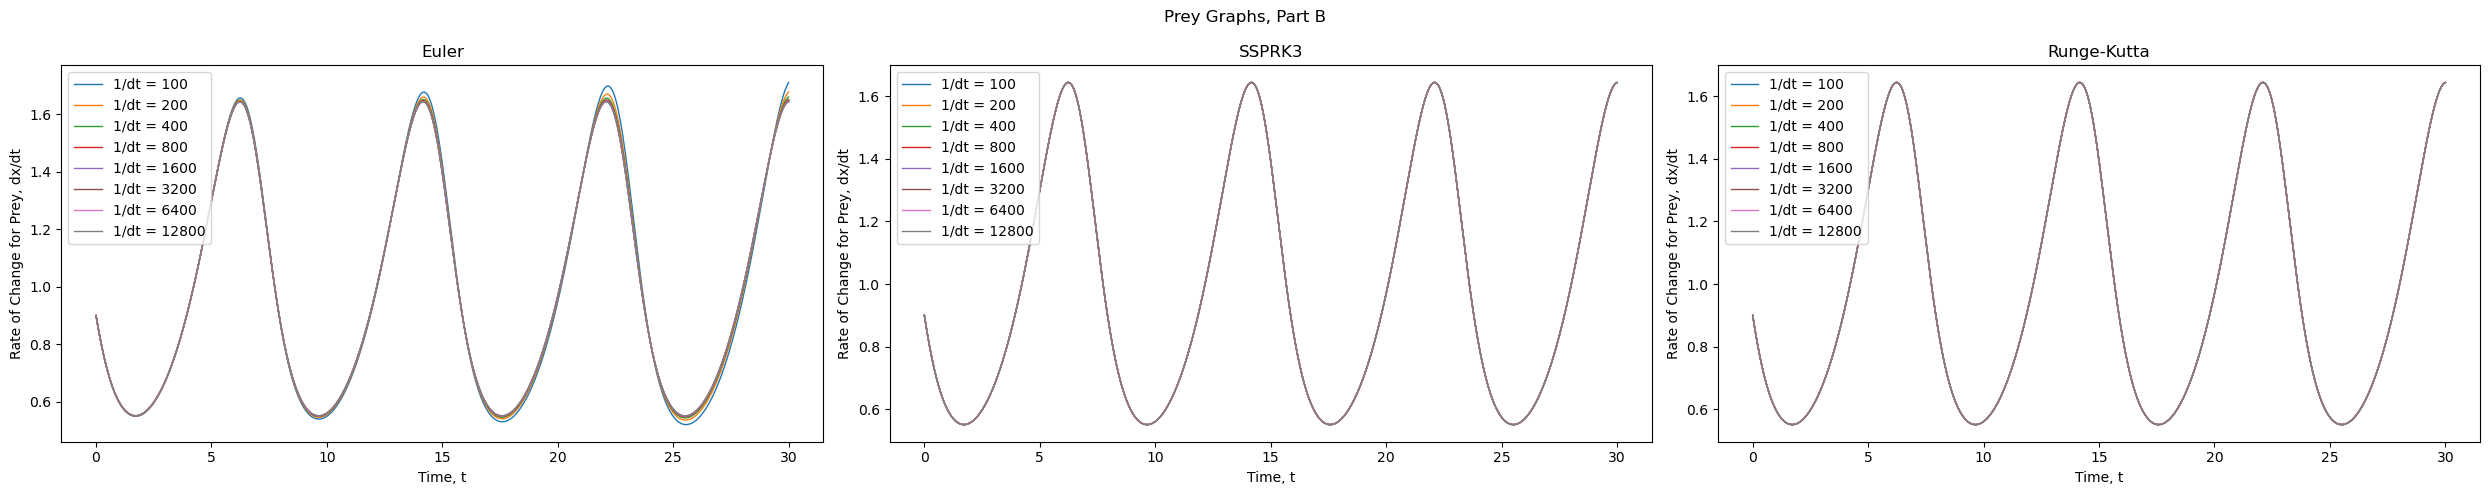

<Figure size 2500x500 with 0 Axes>

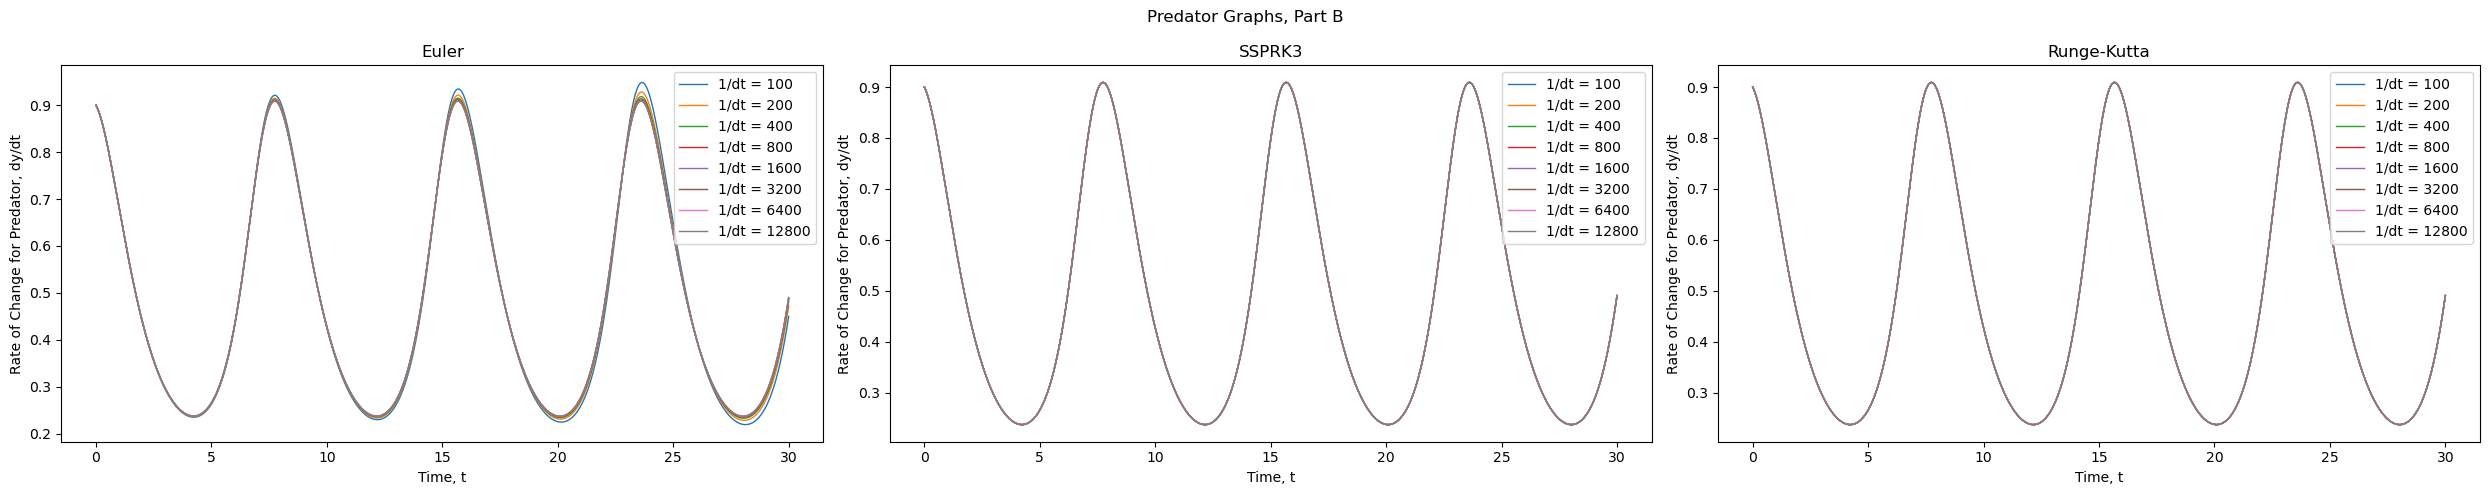

In [12]:
Output_Main_Graphs(Data_To_Store_For_A, "Prey")
Output_Main_Graphs(Data_To_Store_For_A, "Predator")

Output_Main_Graphs(Data_To_Store_For_B, "Prey")
Output_Main_Graphs(Data_To_Store_For_B, "Predator")

Observing the Euler graphs simulated for part B, we observe a general trend in the peaks to increase as time goes along. Since a requirement for this report is that "the maxima of each population should be consistent (i.e. not change) over time", we highlight and analyse this change, as well as with the other methods, via the graphs below.

<Figure size 2500x500 with 0 Axes>

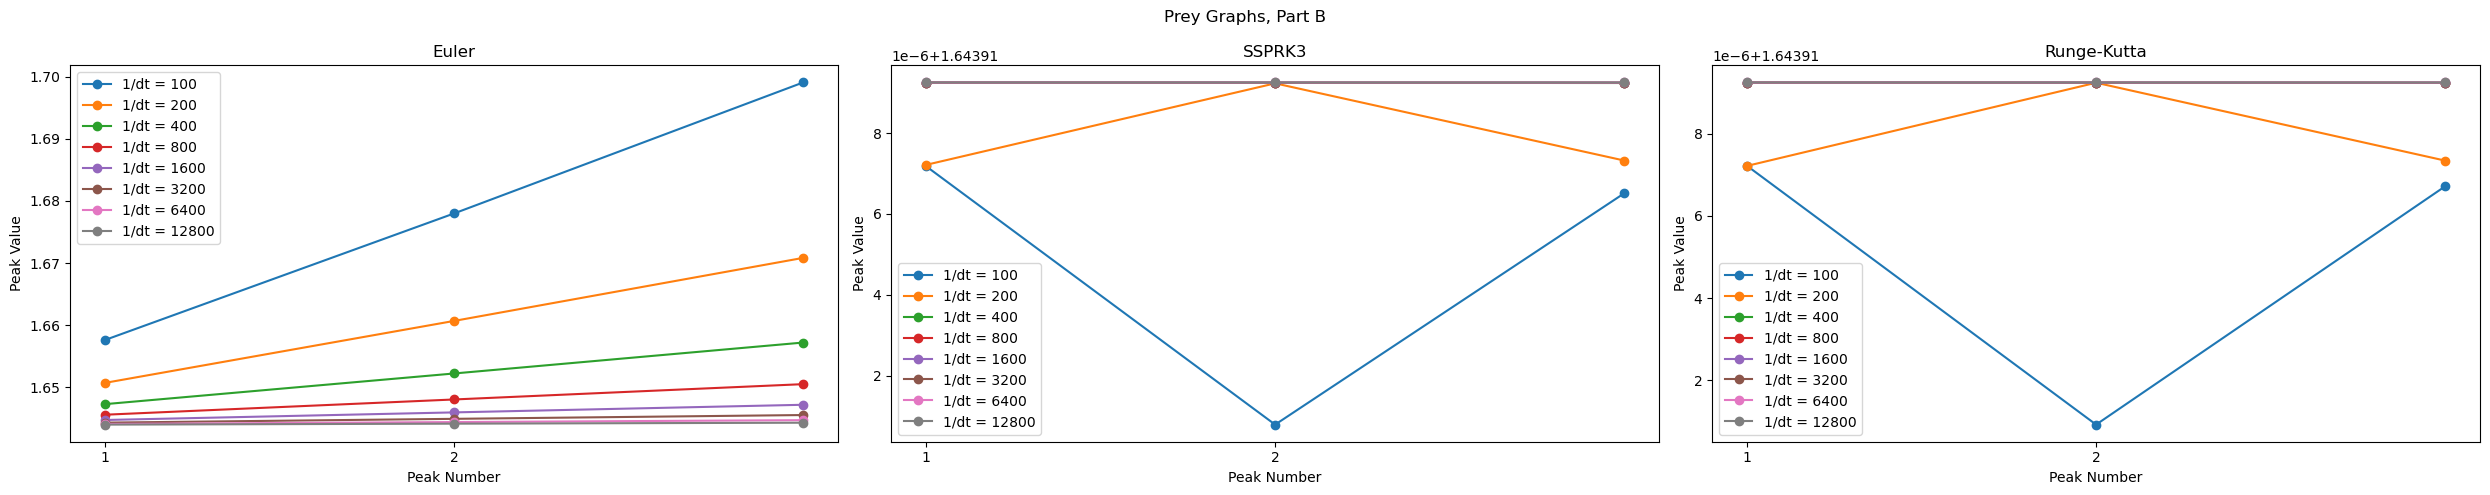

<Figure size 2500x500 with 0 Axes>

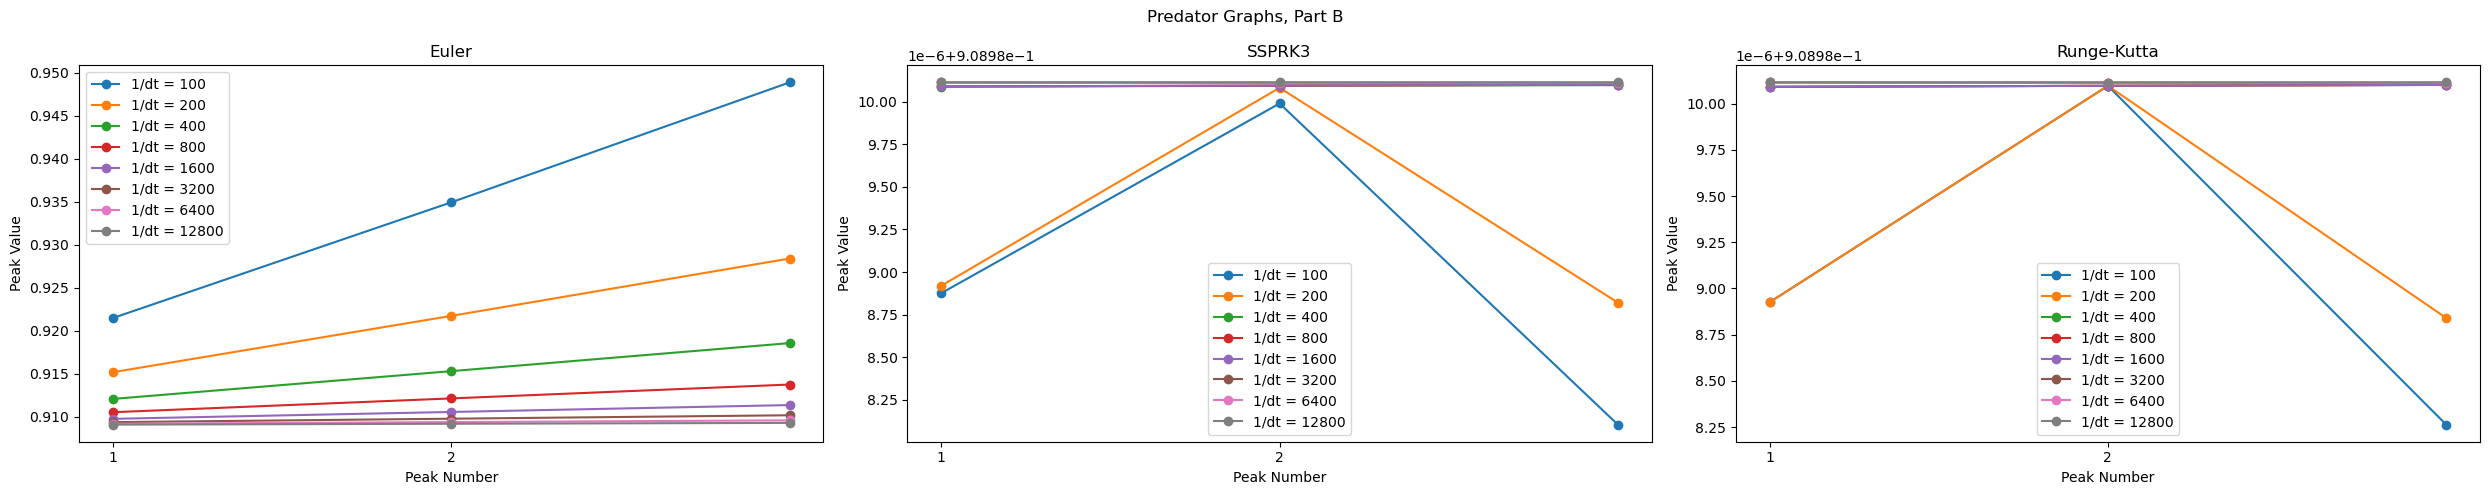

In [13]:
Output_Maxima_Graph_For_Part_B(Data_To_Store_For_B, "Prey")
Output_Maxima_Graph_For_Part_B(Data_To_Store_For_B, "Predator")

To demonstrate the accuracy for the methods highlighted in this report, we use the data provided in part A to calculate the absolute maximum error, absolute average error, and the euclidean norm between the simulated method and its respective true value. We calculate this data according to each size step 1/dt, to observe the trend between the error and the value for 1/dt as it increases.

Error values for Euler method, Predator, part A
╒════════╤══════════════════════════╤══════════════════════════╤══════════════════╕
│   1/dt │   Maximum absolute error │   Average absolute error │   Euclidean norm │
╞════════╪══════════════════════════╪══════════════════════════╪══════════════════╡
│    100 │              0.020174    │              0.00842089  │        0.289532  │
├────────┼──────────────────────────┼──────────────────────────┼──────────────────┤
│    200 │              0.0100227   │              0.00419425  │        0.203693  │
├────────┼──────────────────────────┼──────────────────────────┼──────────────────┤
│    400 │              0.00499546  │              0.00209284  │        0.143676  │
├────────┼──────────────────────────┼──────────────────────────┼──────────────────┤
│    800 │              0.00249379  │              0.00104535  │        0.101468  │
├────────┼──────────────────────────┼──────────────────────────┼──────────────────┤
│   1600 │              0.00

<Figure size 2500x1000 with 0 Axes>

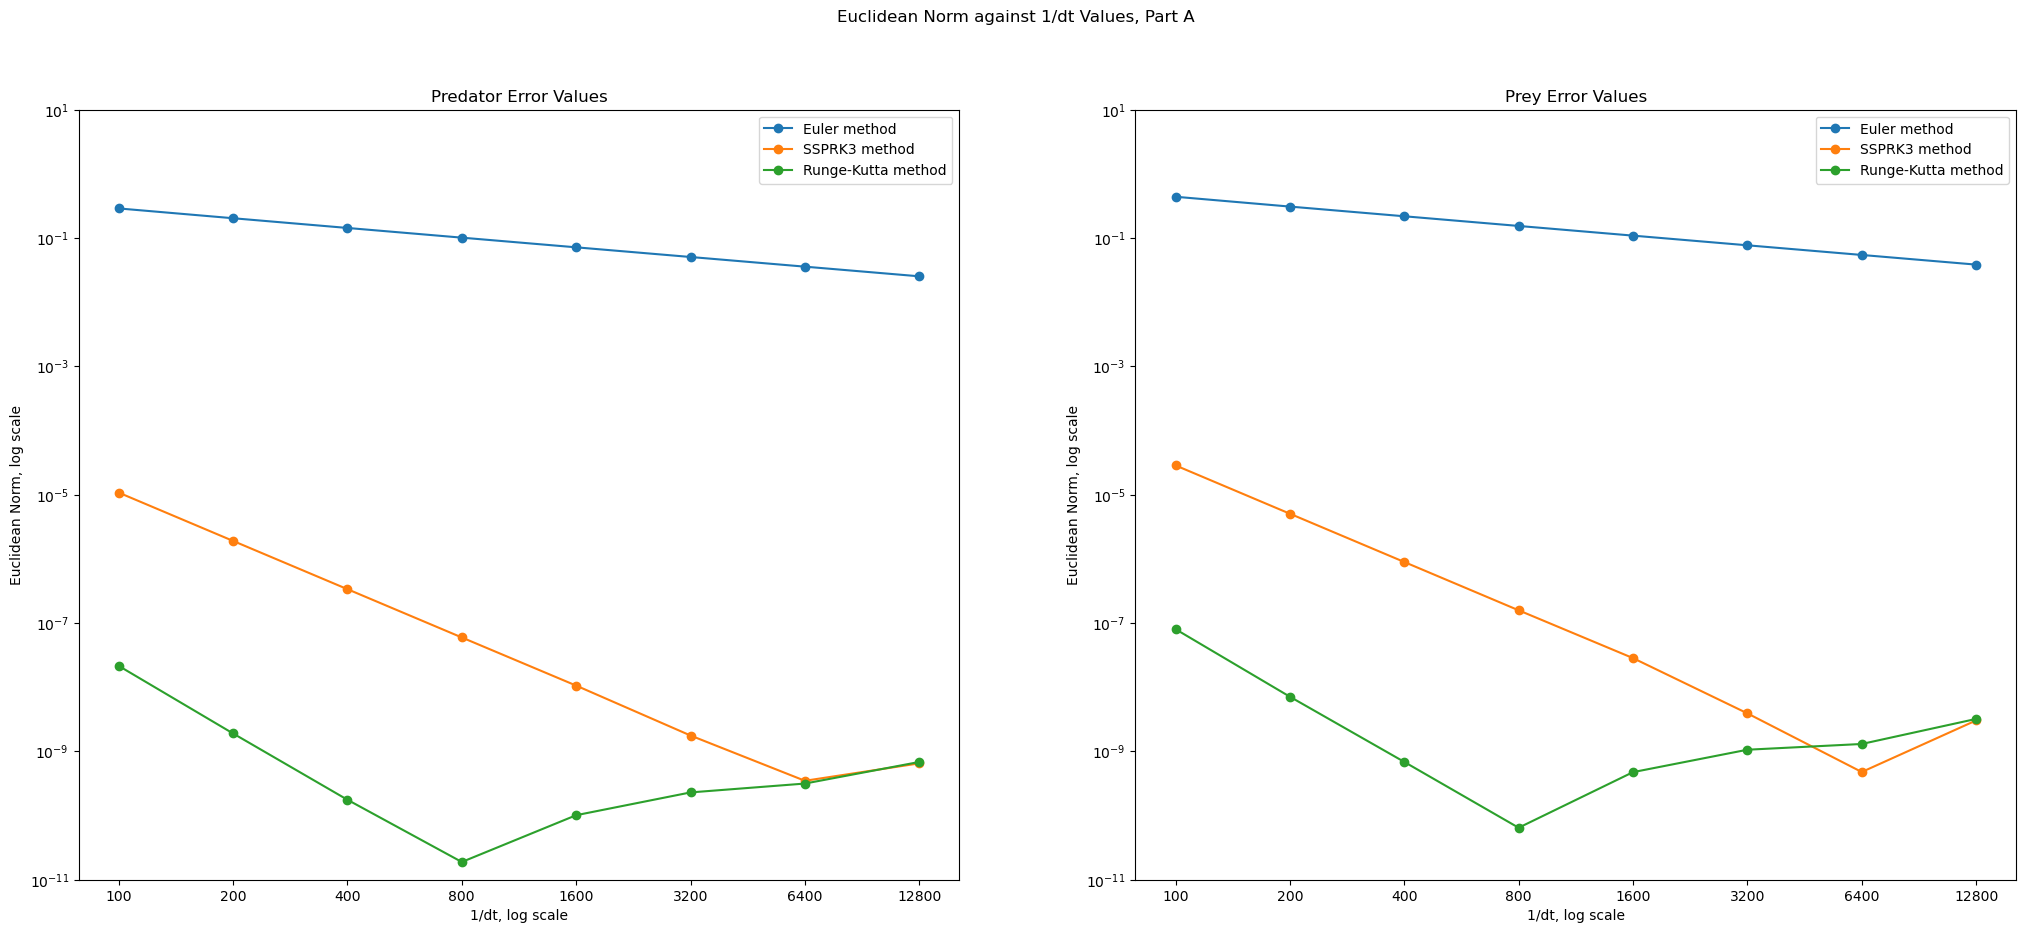

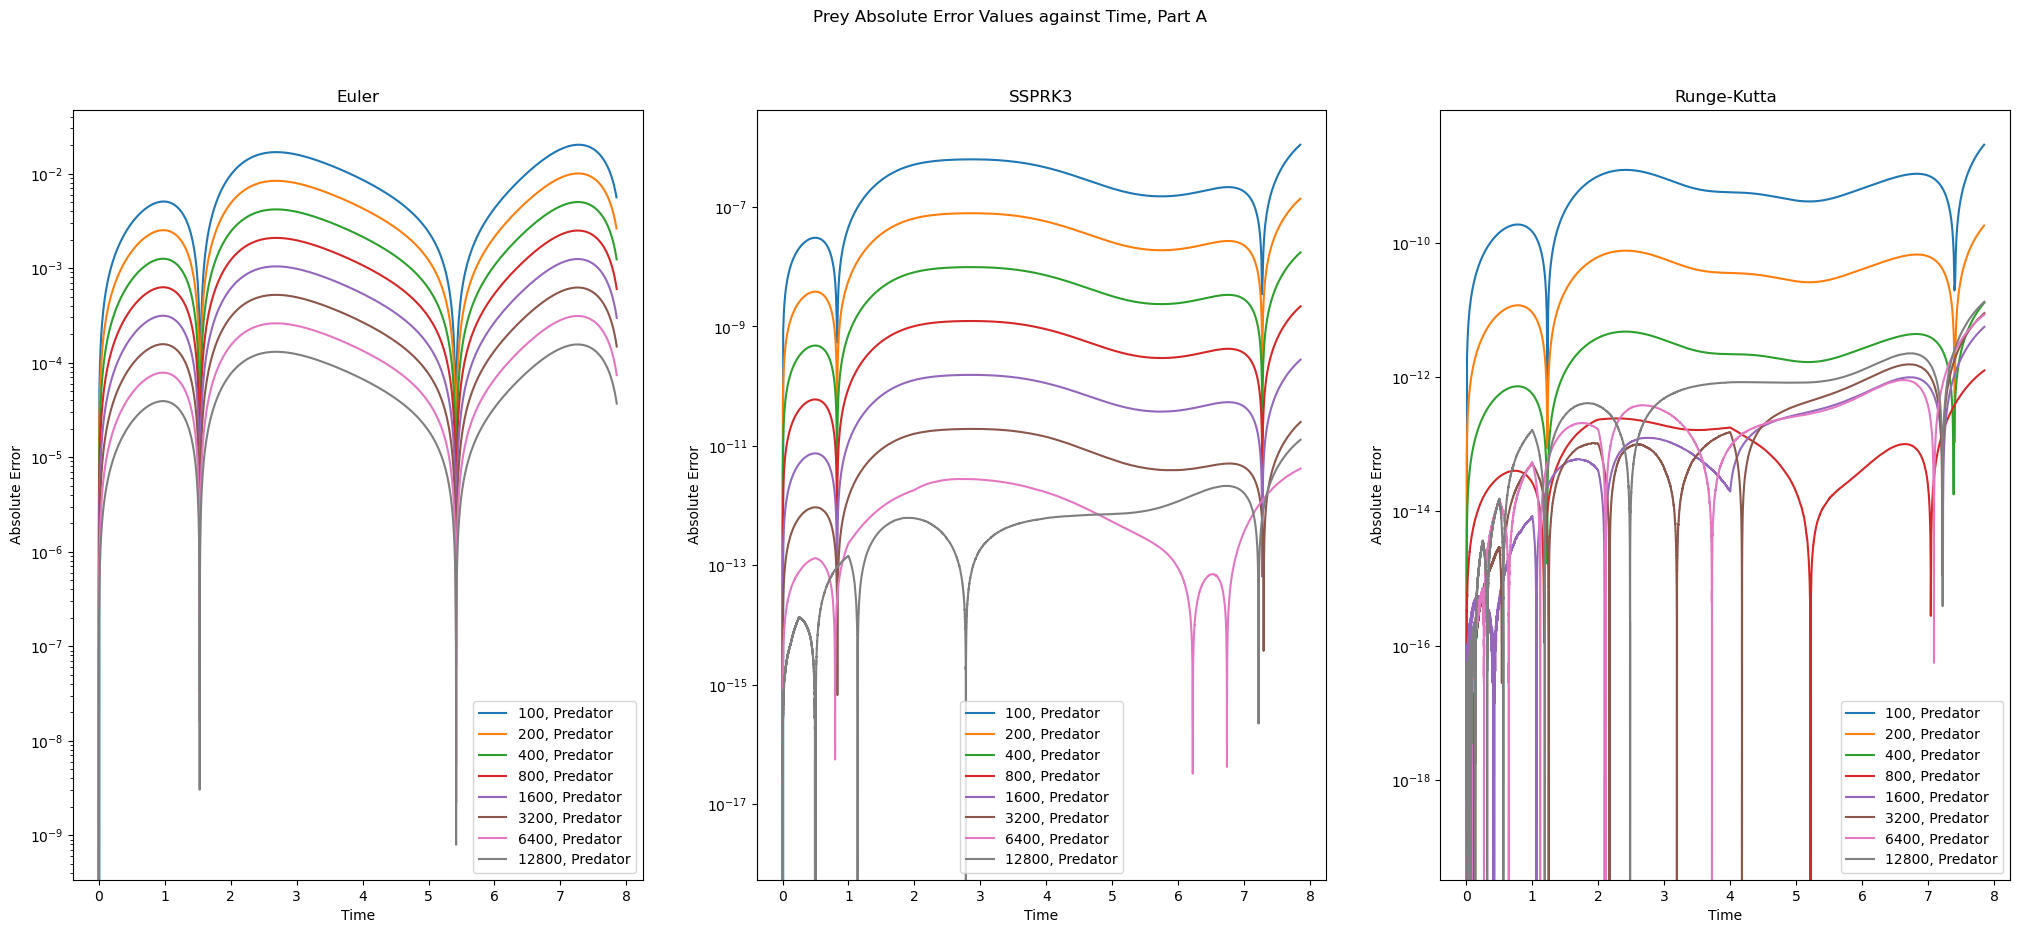

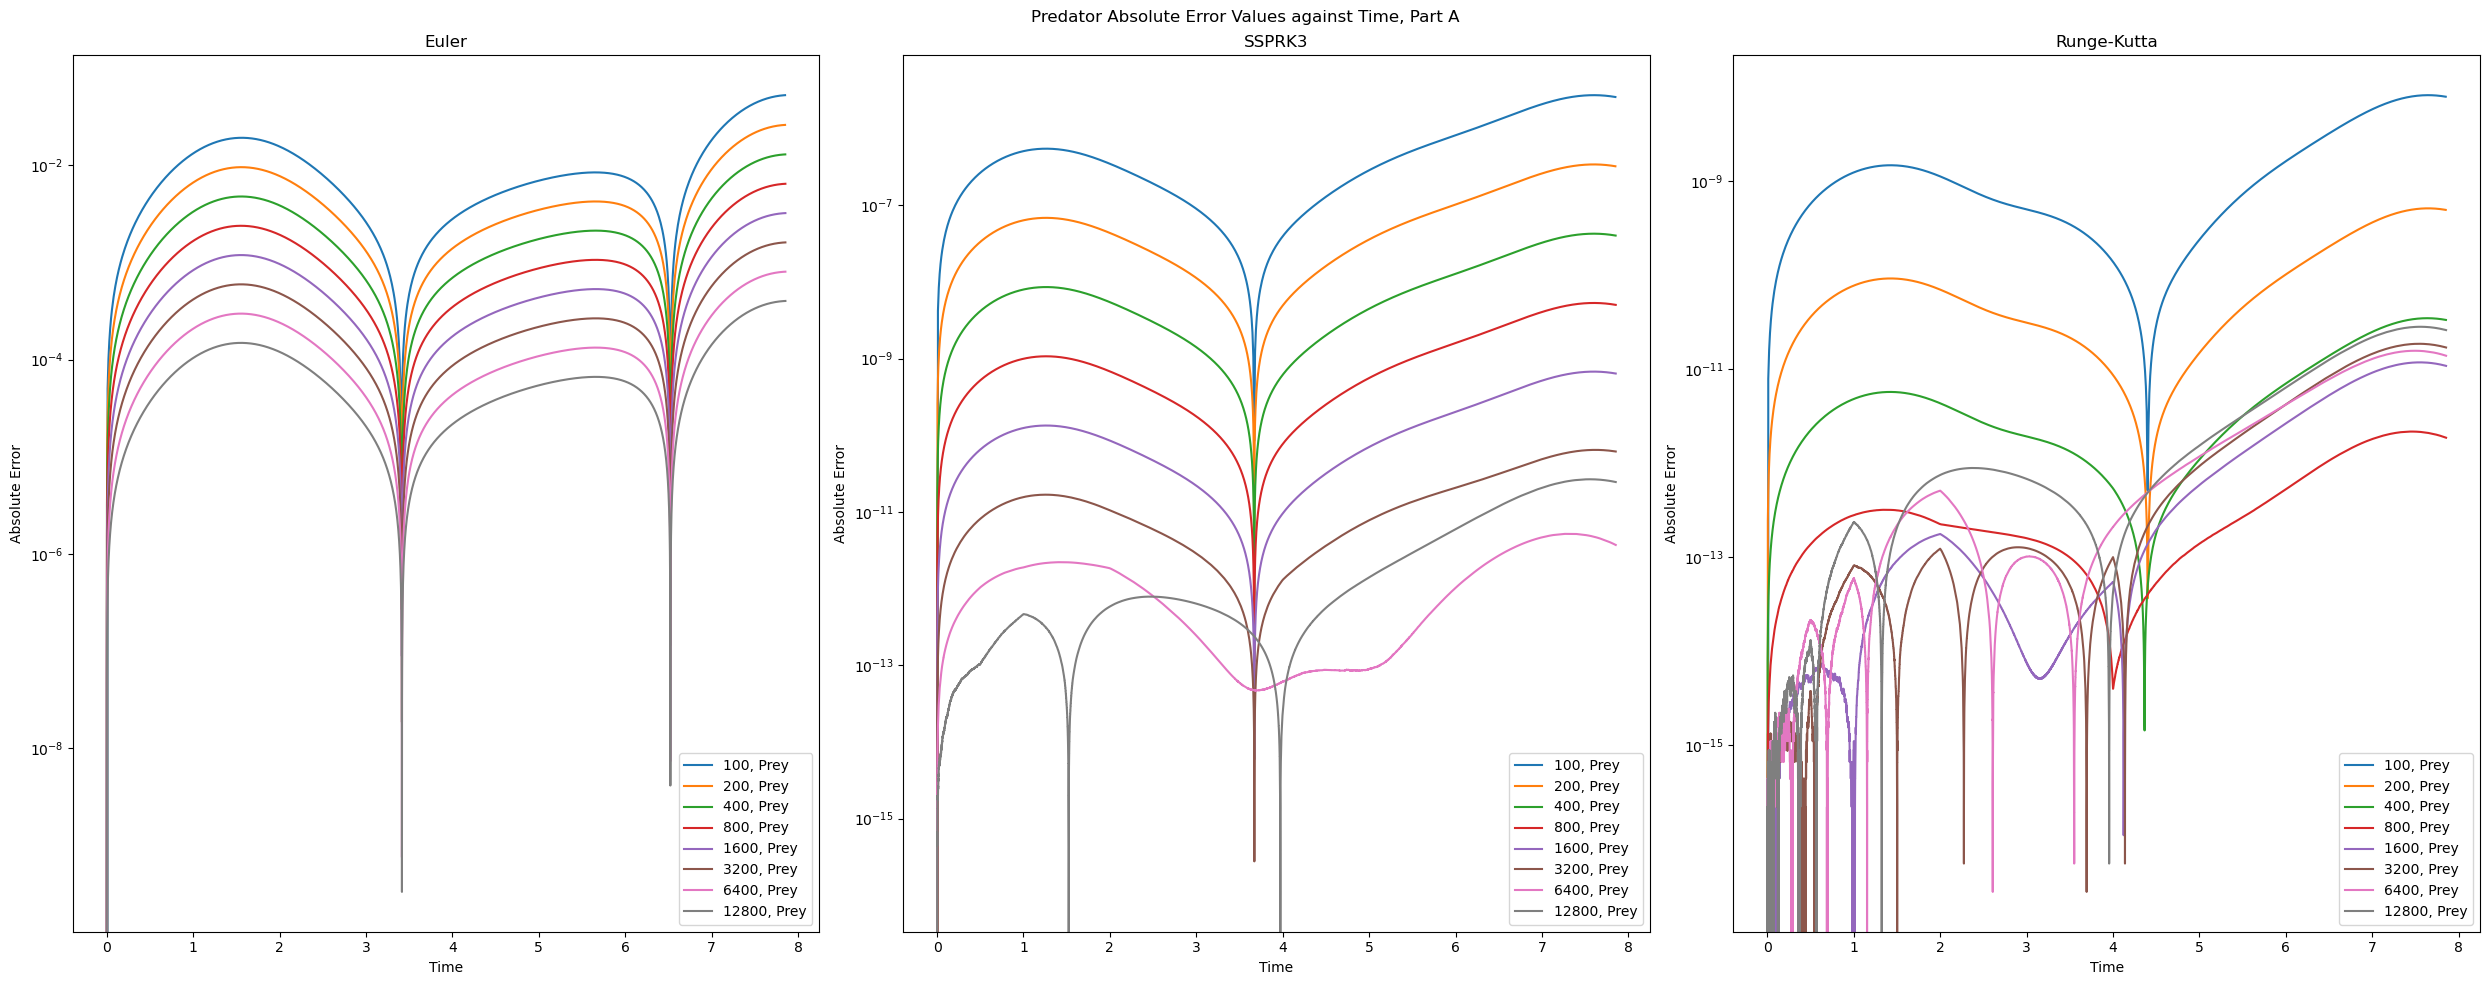

╒═════════════╤═══════════════════╤═══════════════════════════════════╤════════════════════════════════════════════════╤══════════════════════════════════════════════╕
│ Method      │   Order of Method │   Predator Average Error Gradient │   Multiplicative Factor against Euler's Method │   Order Calculated for Predator Error Values │
╞═════════════╪═══════════════════╪═══════════════════════════════════╪════════════════════════════════════════════════╪══════════════════════════════════════════════╡
│ Euler       │                 1 │                         -0.694265 │                                        1       │                                            1 │
├─────────────┼───────────────────┼───────────────────────────────────┼────────────────────────────────────────────────┼──────────────────────────────────────────────┤
│ SSPRK3      │                 3 │                         -2.08606  │                                        3.00471 │                                        

In [14]:
Output_Error_Tables_And_Graphs_For_Part_A()

Finally, we demonstrate how long each process takes by calculating the related times taken to simulate these results. This is calculated by running the process 5 times, or by the number set in the variable TIMES_TO_REPEAT_NUMERICAL_METHOD, and calculating the average based on these 5 running times. All methods are similar in computational process so limited time fluctuations are observed. 1 core of your CPU is dedicated to running this methods, to minimise fluctuations in the final time taken.

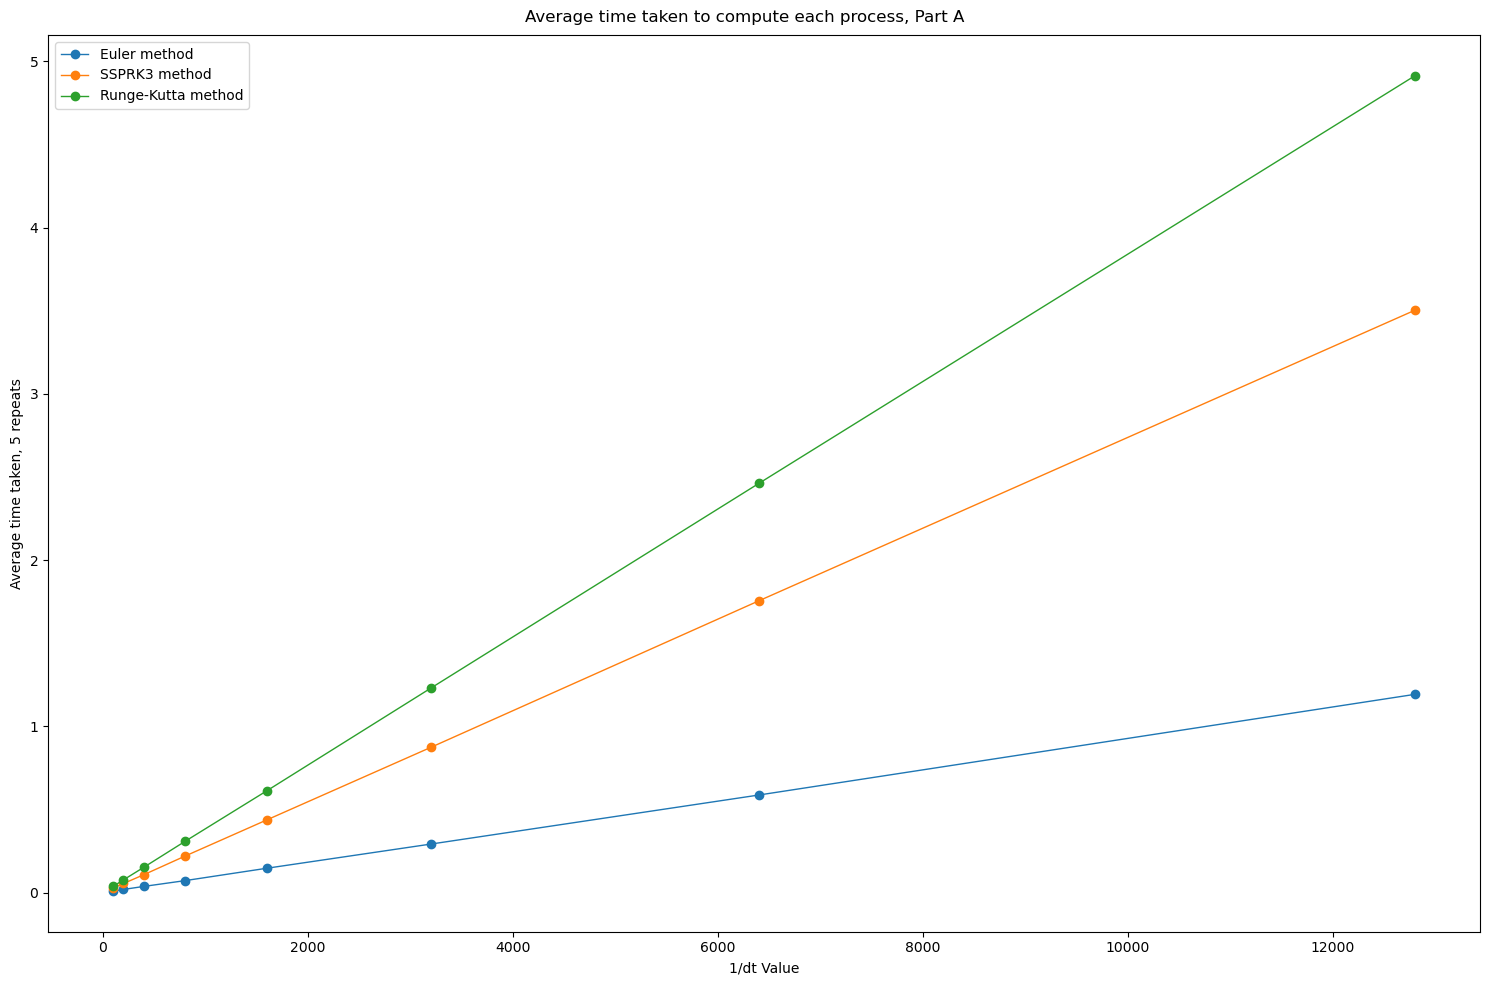

Part A, Calculating Big-O for each Process
╒═════════════╤═════════════╤════════════════════════════════════════════════╤════════════════════════════╤══════════════════════════════╕
│ Method      │    Gradient │   Multiplicative Factor against Euler's Method │ Intended O(n) for Method   │ Calculated O(n) for Method   │
╞═════════════╪═════════════╪════════════════════════════════════════════════╪════════════════════════════╪══════════════════════════════╡
│ Euler       │ 9.16003e-05 │                                         1      │ O(n)                       │ O(n)                         │
├─────────────┼─────────────┼────────────────────────────────────────────────┼────────────────────────────┼──────────────────────────────┤
│ SSPRK3      │ 0.000273802 │                                         2.9891 │ O(3n)                      │ O(3n)                        │
├─────────────┼─────────────┼────────────────────────────────────────────────┼────────────────────────────┼────────────────

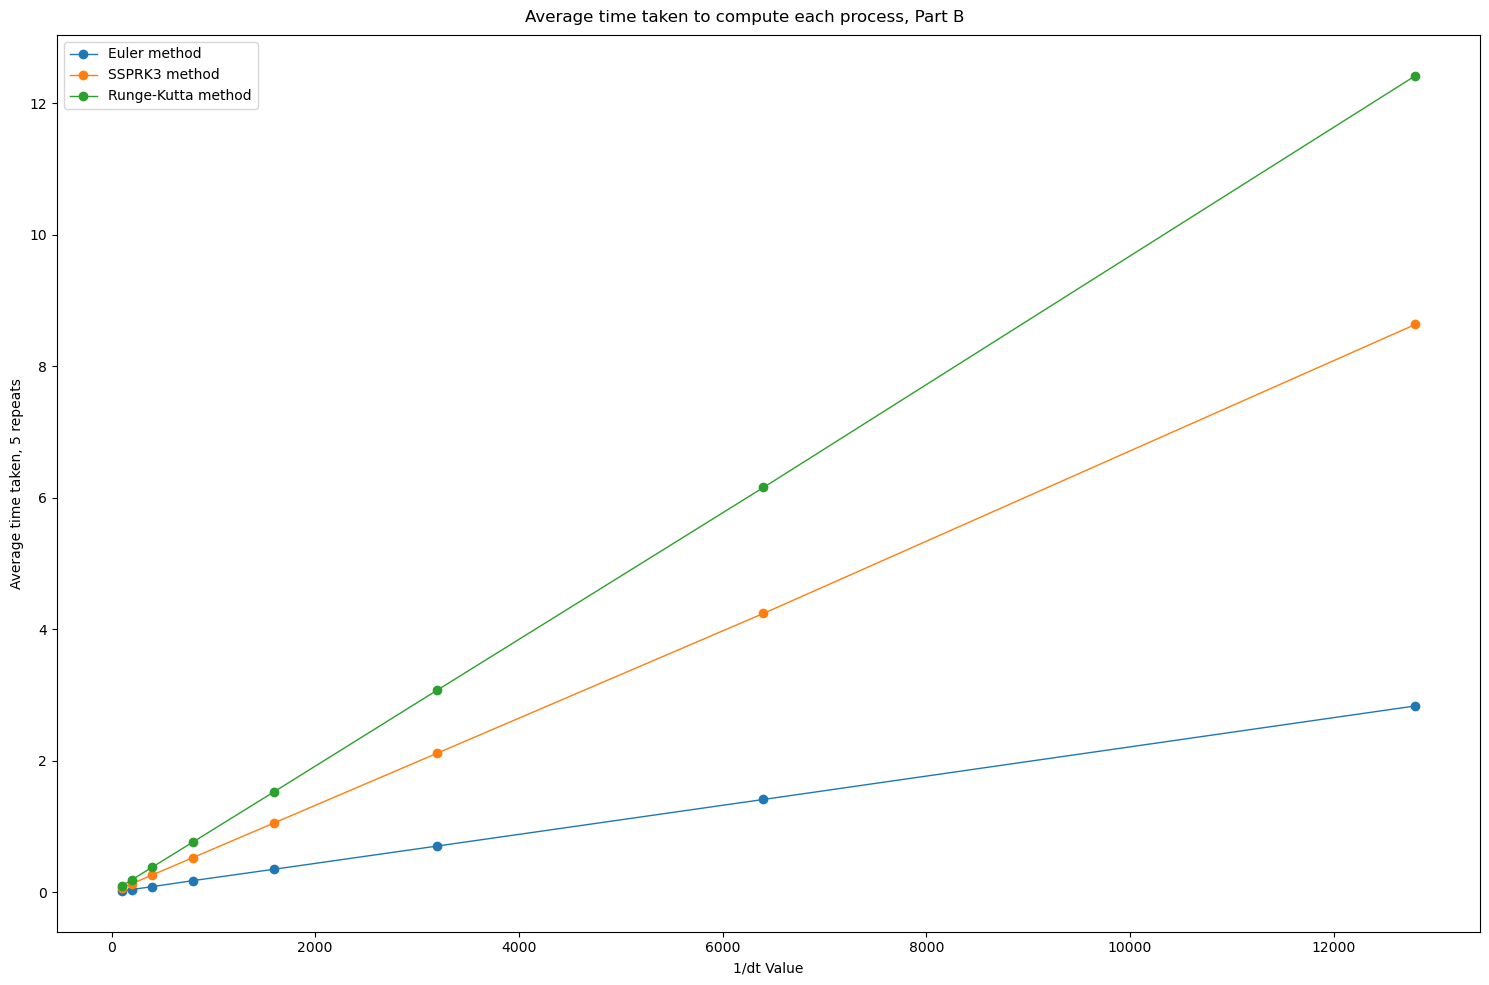

Part B, Calculating Big-O for each Process
╒═════════════╤═════════════╤════════════════════════════════════════════════╤════════════════════════════╤══════════════════════════════╕
│ Method      │    Gradient │   Multiplicative Factor against Euler's Method │ Intended O(n) for Method   │ Calculated O(n) for Method   │
╞═════════════╪═════════════╪════════════════════════════════════════════════╪════════════════════════════╪══════════════════════════════╡
│ Euler       │ 0.000221113 │                                        1       │ O(n)                       │ O(n)                         │
├─────────────┼─────────────┼────────────────────────────────────────────────┼────────────────────────────┼──────────────────────────────┤
│ SSPRK3      │ 0.000664427 │                                        3.00493 │ O(3n)                      │ O(3n)                        │
├─────────────┼─────────────┼────────────────────────────────────────────────┼────────────────────────────┼────────────────

: 

In [15]:
Output_Time_Graph(Data_To_Store_For_A, True)
print("\n\n\n\n")
Output_Time_Graph(Data_To_Store_For_B, False)

## Analysis
In general, all 3 methods demonstrate reasonably good accuracy for simulating the conditions for parts A and B. There is the issue for the peaks when calculating the Euler method for part B, where the height of the peaks tends to increase as time increases. This is highlighted and compared against the other methods (SSPRK3 and Runge-Kutta), which possess little to no evidence for this trend. The trend for these methods instead dictates relative consistency on certain 1/dt values, while also displaying very minor fluctuations between peaks at the order of 1e-6. As such, the Euler method may not be as suitable for calculating long timelines of these Lokta-Volterra equations based on this analysis.

To comment on the accuracy for each method, it was necessary to calculate 1/dt values from 1/dt = 100 towards 1/dt = 12800, so that a general overall trend could be observed and studied. Using part A due to the provided true values for each equation, absolute errors and the Euclidean norm could be calculated with a high degree of accuracy. In the context of the methods, a lower Euclidean norm means a more accurate method and 1/dt paired value. The trends observed from these graphs were interesting, but somewhat expected, where the Euler, SSPRK3 and Runge-Kutta (RK-4) methods each displayed a general negative trend for the average error, maximum error and Euclidean norm. Graphs for the absolute error against time showed a tendency for the error values to be at the maximum towards the end of the simulation, and a breakdown for the trends in error values as the 1/dt value was halved, which could be attributed to instability issues. The Euler method was used as the baseline to compare the gradients of each method (the gradient for the average error), where each method produced ratios of 1, 3 and 4 for the Euler, SSPRK3 and RK-4 methods (at least until the slope of the SSPRK3 and RK-4 graphs began to increase). This trend was expected due to the order for each method being orders 1, 3 and 4 respectively (ChatGPT 3.5, 2023), and how the order for each method corresponds with the absolute error by the equation $Error \approx C * h^p$, where C is some constant, E is the absolute error, p is the order for the method and h is the step size (Wikipedia contributors, 2023). A trend for a doubling in step size (1/dt) caused the error to decrease by a factor of 2 for a method, until some threshold. For the SSPRK3 and RK-4 methods, this threshold was reached at 1/dt values 6400 and 800 respectively, again likely indicating instability issues (ChatGPT 3.5, 2023) as the trend for these methods begins to increase sporadically afterwards, particularly highlighted in the graphs for Euclidean norm against 1/dt intervals. Overall, the RK-4 method exhibited the greatest accuracy at a 1/dt value of 800 and a Euclidean norm magnitude of approximately $10^{-10}$, followed by the SSPRK3 method at a 1/dt value of 6400 and its Euclidean norm of $10^{-9}$, and finally the Euler method, which does not have a conclusive final 1/dt value since this would require too much computational processing power and time.

As for calculating the efficiency, each method was timed on 1 separate core (to create stability for execution and accurate measurements for time taken) for each dt value 5 times. A plot for the average times against each dt value was created, showing a positive linear trend/gradient. The indicated Big-O notation for the Euler, SSPRK3 and RK-4 methods all are indicated to be O(n), however the gradient for each method scaled according to the order of each method (as shown by the Big-O tables). This was expected, as the formula for calculating the Big-O for each method stands at $T = O(p*n)$, where T = time taken, p = order of method, and n is the number of elements to calculate (ChatGPT 3.5, 2023). Given this formula and the results, it stands to reason that the order of a method, and the value for 1/dt, is directly proportional to the expended time taken, noted by the doubling for all 1/dt values. As such, RK-4 takes the longest, followed by SSPRK3, then Euler's method.

## Conclusion

Overall, I believe the best method for simulation is the Runge-Kutta method (RK-4), due to the very low order of magnitude (approximately $ 10^{-10}$) for the absolute error achieved in a very small 1/dt value of 800 compared to other methods. The time required to calculate this value was also comparatively small, where the SSPRK3 method and its lowest 1/dt value of 1/6400 (producing an Euclidean norm value with an order of magnitude of approximately $ 10^{-9}$), took approximately 3 times longer to compute against the RK-4 method. The RK-4 method exhibits an extremely high peak to peak stability performance in part B compared to the baseline Euler's method, and while the stability for the RK-4 method is questionable for larger 1/dt values, it stands to perform the best out of the 3 chosen methods, providing a much higher accuracy and efficiency compared to the SSPRK3 and Euler methods due to the order of the method being 4, compared to 3 and 1 respectively. As such, the RK-4 method stands to operate the best out of the 3 methods, and would be an excellent fit for calculating the predator-prey models the company would like to simulate.

# References
ChatGPT 3.5, 2023. ChatGPT. Available from: https://chat.openai.com/c/888b3bb9-8579-498f-9a3e-ccdf6b665363.

Wikipedia contributors 2023. Order of accuracy. Wikipedia. [Online]. Available from: https://en.wikipedia.org/wiki/Order_of_accuracy.